In [ ]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import gc
from tqdm import tqdm
from torchvision.utils import save_image
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer, CLIPTextModel

class GuidedSampler:
    def __init__(self, model_id="benetraco/latent_finetuning", resolution=32, num_inference_steps=999, device="cuda", seed=17844):
        self.device = device
        self.seed = seed
        self.resolution = resolution
        self.generator = torch.manual_seed(seed)
        self.num_inference_steps = num_inference_steps

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
        self.pipe.to(device)

        self.unet = self.pipe.unet
        self.vae = self.pipe.vae
        self.scheduler = self.pipe.scheduler
        self.tokenizer = self.pipe.tokenizer
        self.text_encoder = self.pipe.text_encoder

        # Set scheduler inference steps
        self.scheduler.set_timesteps(self.num_inference_steps)

    def _get_embeddings(self, prompt):
        tokens = self.tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt")
        tokens = {k: v.to(self.device) for k, v in tokens.items()}
        with torch.no_grad():
            return self.text_encoder(**tokens).last_hidden_state

    def sample(self, prompts, guidance_values=[2.0], batch_size=1, output_dir="guided_outputs"):
        os.makedirs(output_dir, exist_ok=True)
        uncond_emb = self._get_embeddings("")

        for prompt in prompts:
            text_emb = self._get_embeddings(prompt)
            tag = prompt.split()[0].lower()

            latents = torch.randn(batch_size, 4, self.resolution, self.resolution, generator=self.generator).to(self.device)
            latents *= self.scheduler.init_noise_sigma

            for g in guidance_values:
                l = latents.clone()
                for t in tqdm(self.scheduler.timesteps, desc=f"{tag} | guidance {g}"):
                    l = self.scheduler.scale_model_input(l, t)

                    with torch.no_grad():
                        n_uncond = self.unet(l, t, encoder_hidden_states=uncond_emb.expand(batch_size, -1, -1)).sample
                        n_text = self.unet(l, t, encoder_hidden_states=text_emb.expand(batch_size, -1, -1)).sample
                        n = n_uncond + g * (n_text - n_uncond)

                    l = self.scheduler.step(n, t, l).prev_sample

                l /= self.vae.config.scaling_factor
                with torch.no_grad():
                    decoded = self.vae.decode(l).sample.cpu()

                for i in range(batch_size):
                    save_path = os.path.join(output_dir, f"{tag}_g{g}_img{i}.png")
                    save_image(decoded[i], save_path)

                del l, decoded, n, n_uncond, n_text
                gc.collect()
                torch.cuda.empty_cache()

# Run the sampler
if __name__ == "__main__":
    sampler = GuidedSampler(model_id="benetraco/latent_finetuning_prova", resolution=32)
    sampler.sample(
        prompts=["SHIFTS FLAIR MRI", "VH FLAIR MRI", "WMH2017 FLAIR MRI"],
        guidance_values=[0.0, 1.0, 2.0, 3.0],
        batch_size=1,
        output_dir="outputs"
    )


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
shifts | guidance 0.0: 100%|██████████| 999/999 [01:04<00:00, 15.42it/s]
shifts | guidance 1.0: 100%|██████████| 999/999 [01:04<00:00, 15.42it/s]
shifts | guidance 2.0: 100%|██████████| 999/999 [01:06<00:00, 14.96it/s]
shifts | guidance 3.0: 100%|██████████| 999/999 [01:05<00:00, 15.17it/s]
vh | guidance 0.0:  13%|█▎        | 125/999 [00:08<00:58

KeyboardInterrupt: 

: 

  0%|          | 0/999 [00:00<?, ?it/s]

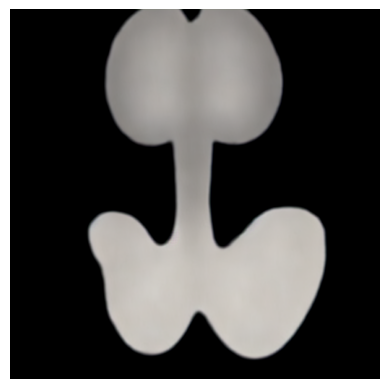

In [4]:
import matplotlib.pyplot as plt
# Generate a brain MRI image in SHIFTS style
prompt = "SHIFTS FLAIR MRI"
image = pipe(prompt=prompt, num_inference_steps=999, guidance_scale=2.0).images[0]


plt.imshow(image)
plt.axis("off")
plt.show()


# Notebook to test generation and evaluation metrics

In [1]:
from pytorch_fid import fid_score


In [2]:
dataset1_path = 'generated_images/brain_ddpm_'
dataset2_path = 'test_images/'

fid_value_64 = fid_score.calculate_fid_given_paths([dataset1_path+'64', dataset2_path+'64'], batch_size=50,device='cuda:0', dims=2048)  # InceptionV3 dimension
print(f'FID score for 64x64 images: {fid_value_64}')
fid_value_128 = fid_score.calculate_fid_given_paths([dataset1_path+'128', dataset2_path+'128'], batch_size=50,device='cuda:0', dims=2048)  # InceptionV3 dimension
print(f'FID score for 128x128 images: {fid_value_128}')
fid_value_256 = fid_score.calculate_fid_given_paths([dataset1_path+'256', dataset2_path+'256'], batch_size=50,device='cuda:0', dims=2048)  # InceptionV3 dimension
print(f'FID score for 256x256 images: {fid_value_256}')

100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


FID score for 64x64 images: 87.86227175679312


100%|██████████| 5/5 [00:00<00:00,  7.42it/s]


FID score for 128x128 images: 139.93234516951776


100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


FID score for 256x256 images: 204.65910406651412


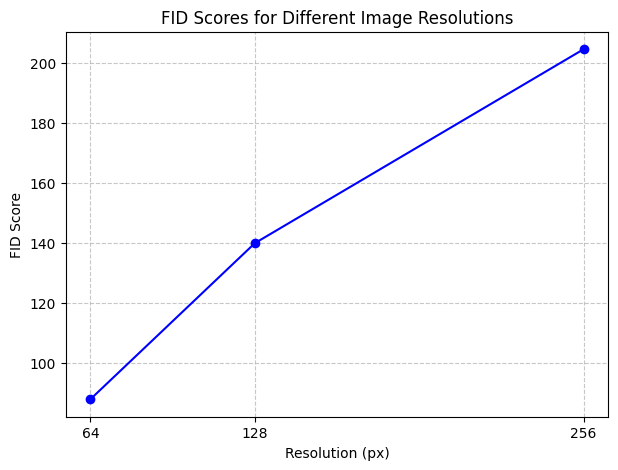

In [3]:
import matplotlib.pyplot as plt

# FID values for each resolution
resolutions = [64, 128, 256]
fid_values = [fid_value_64, fid_value_128, fid_value_256]  # Replace these with your actual FID values

# Plotting the FID scores
plt.figure(figsize=(7, 5))
plt.plot(resolutions, fid_values, marker='o', linestyle='-', color='b')
plt.title('FID Scores for Different Image Resolutions')
plt.xlabel('Resolution (px)')
plt.ylabel('FID Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(resolutions)
plt.show()


In [ ]:
import torch

import sys
sys.path.append('/home/benet/scenic')
from scenic.projects.baselines.clip import model as clip
print("Scenic CLIP model imported successfully!")

sys.path.append('/home/benet/tfg/experiments/brain_generation/evaluation/google-research')
import cmmd.main as cmmd_main
compute_cmmd = cmmd_main.compute_cmmd

dataset1_path_64 = 'generated_images/brain_ddpm_64'
dataset2_path_64 = 'test_images/64'

# Compute CMMD
cmmd_value_64 = compute_cmmd(dataset1_path_64, dataset2_path_64, batch_size=32, max_count=-1)
print(f"CMMD score for 64x64 images: {cmmd_value_64}")


2025-05-12 13:13:56.043707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747048436.066079 1373266 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747048436.072819 1373266 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747048436.089659 1373266 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747048436.089686 1373266 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747048436.089688 1373266 computation_placer.cc:177] computation placer alr

Scenic CLIP model imported successfully!


Calculating embeddings for 240 images from generated_images/brain_ddpm_64.


I0000 00:00:1747048450.163875 1373266 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2556 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
I0000 00:00:1747048450.164476 1373266 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1812 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1
I0000 00:00:1747048450.164971 1373266 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 119 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1
100%|██████████| 7/7 [04:16<00:00, 36.63s/it]


Calculating embeddings for 234 images from test_images/64.


100%|██████████| 7/7 [03:46<00:00, 32.34s/it]


CMMD score for 64x64 images: 0.5723039507865906


: 

In [ ]:
import os
import sys
from pathlib import Path
from tqdm import tqdm

# Get the absolute path to the PerceptualSimilarity directory
module_path = Path().resolve() / "PerceptualSimilarity"

# Add it to the Python path
sys.path.append(str(module_path))

# Now you can import lpips
import lpips

dataset1_path_64 = 'generated_images/brain_ddpm_64'
dataset2_path_64 = 'test_images/64'
out = 'evaluation_results/lpips_64.txt'

loss_fn = lpips.LPIPS(net='alex',version='0.1').cuda()

# crawl directories
f = open(out,'w')
files_1 = os.listdir(dataset1_path_64)
files_2 = os.listdir(dataset2_path_64)
# Initialize variables for accumulation
distances = []

# Compute distances with tqdm progress bar
for file1 in tqdm(files_1, desc="Computing LPIPS distances"):
    for file2 in files_2:
        img1 = lpips.im2tensor(lpips.load_image(os.path.join(dataset1_path_64, file1))).cuda()
        img2 = lpips.im2tensor(lpips.load_image(os.path.join(dataset2_path_64, file2))).cuda()
        dist = loss_fn(img1, img2)
        distances.append(dist.item())

# Convert to tensor for easier computation
distances_tensor = torch.tensor(distances)
avg_dist = distances_tensor.mean().item()
std_dist = distances_tensor.std().item()

print(f'Average LPIPS distance for 64x64 images: {avg_dist}')
f.write(f'Average LPIPS distance for 64x64 images: {avg_dist}\n')

f.close()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/benet/anaconda3/envs/benetvicorob/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benet/anaconda3/envs/benetvicorob/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/benet/tfg/experiments/brain_generation/evaluation/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


Computing LPIPS distances:   3%|▎         | 8/240 [00:08<03:58,  1.03s/it]


KeyboardInterrupt: 

: 

In [ ]:

dataset1_path_64 = 'generated_images/brain_ddpm_64'
dataset2_path_64 = 'test_images/64'

# Compute CMMD
cmmd_value_64 = compute_cmmd(dataset1_path_64, dataset2_path_64, batch_size=32, max_count=-1)
print(f"CMMD score for 64x64 images: {cmmd_value_64}")


ERROR:absl:Could not import torch for CLIP checkpoint conversion


UnboundLocalError: cannot access local variable 'torch' where it is not associated with a value